In [1]:
from sklearn.datasets import load_boston

Use `load_boston` to load the Boston Housing Dataset.
You must create a Linear Regression model fitted to this data to predict house prices.

- Check the data for nulls
- Explore the data, distributions, correlations.
- Take that into mind when choosing the features for your model.
- Watch out for colinearity.
- Split your data into train and test. [Check out how!](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
- Measure the goodness of your fit! $R^2$, $RMSE$, etc.
- Try to make it better.
- Do your own research. Checkout both sklearn and statsmodels, get a feel of both.
- Have fun.


### Further resources

- [The internet is your friend](https://towardsdatascience.com/simple-and-multiple-linear-regression-with-python-c9ab422ec29c)
- [Scikit-Learn](https://scikit-learn.org)
- [Statsmodels](https://statsmodels.org)

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing

import statsmodels.api as smf

from sklearn.utils import shuffle

Load the dataset

In [3]:
boston = load_boston()
boston.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])

Print descripyion to understand the data

In [4]:
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [5]:
df = pd.DataFrame(boston.data, columns=boston.feature_names)
y = pd.Series(boston.target)

Creating DataFrame for the features (df) and Series for the target (y)

In [6]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


Check for nan: no one found

In [7]:
df.isna().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
dtype: int64

#### CATEGORICAL DATA
- CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
- RAD      index of accessibility to radial highways

Some categories do not have much datapoints (<40)

In [8]:
df["CHAS"].value_counts()

0.0    471
1.0     35
Name: CHAS, dtype: int64

In [9]:
df["RAD"].value_counts()

24.0    132
5.0     115
4.0     110
3.0      38
6.0      26
8.0      24
2.0      24
1.0      20
7.0      17
Name: RAD, dtype: int64

Creating dummies categorical columns for the RAD indexes

In [10]:
dummies = pd.get_dummies(df['RAD'])
cols = []
for col in dummies.columns:
    cols.append("RAD "+str(int(col)))

dummies.columns=cols
dummies.head()

,RAD 1,RAD 2,RAD 3,RAD 4,RAD 5,RAD 6,RAD 7,RAD 8,RAD 24
0,1,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0


Joining the dummies and the target

In [11]:
df=df.join(dummies)
df["TARGET"] = y

Check correlations between variables and the target

In [12]:
correl =df.corr()["TARGET"][:-1]
correl

CRIM      -0.388305
ZN         0.360445
INDUS     -0.483725
CHAS       0.175260
NOX       -0.427321
RM         0.695360
AGE       -0.376955
DIS        0.249929
RAD       -0.381626
TAX       -0.468536
PTRATIO   -0.507787
B          0.333461
LSTAT     -0.737663
RAD 1      0.040453
RAD 2      0.104444
RAD 3      0.167352
RAD 4     -0.065711
RAD 5      0.187356
RAD 6     -0.039411
RAD 7      0.092802
RAD 8      0.190053
RAD 24    -0.396297
Name: TARGET, dtype: float64

Check low correlations using a $ |\rho| \lt 0.4 $ treshold to discard variables not correlated with the housing price:

![plot](http://4.bp.blogspot.com/-x4mHpvd3Exk/Uw9hhfZqZwI/AAAAAAAAEes/pJuiDgyaaGA/s1600/Screen+Shot+2014-02-27+at+11.01.41+AM.png)

In [13]:
correl[abs(correl)<0.30]

CHAS     0.175260
DIS      0.249929
RAD 1    0.040453
RAD 2    0.104444
RAD 3    0.167352
RAD 4   -0.065711
RAD 5    0.187356
RAD 6   -0.039411
RAD 7    0.092802
RAD 8    0.190053
Name: TARGET, dtype: float64

In [14]:
correl[abs(correl)>0.30]

CRIM      -0.388305
ZN         0.360445
INDUS     -0.483725
NOX       -0.427321
RM         0.695360
AGE       -0.376955
RAD       -0.381626
TAX       -0.468536
PTRATIO   -0.507787
B          0.333461
LSTAT     -0.737663
RAD 24    -0.396297
Name: TARGET, dtype: float64

As "RAD" and "RAD 24" are equivalent, so I will use only "RAD 24", to use it as a categorical variable with 0 or 1. This is to use it in the fits to check if the house have high index of accessibility to radial highways or not.

The river dummy variable (= 1 if tract bounds river) and the weighted distance to five Boston employment centres seems that have very low correalation with the housing.

We redefine the dataset with these findings.

In [15]:
df=df[correl[abs(correl)>0.40].index]
#df=df.drop(columns='RAD')
#df=df.rename({"RAD 24":"RAD"})
df.head()

,INDUS,NOX,RM,TAX,PTRATIO,LSTAT
0,2.31,0.538,6.575,296.0,15.3,4.98
1,7.07,0.469,6.421,242.0,17.8,9.14
2,7.07,0.469,7.185,242.0,17.8,4.03
3,2.18,0.458,6.998,222.0,18.7,2.94
4,2.18,0.458,7.147,222.0,18.7,5.33


Checking colinearity

In [16]:
df.corr()

,INDUS,NOX,RM,TAX,PTRATIO,LSTAT
INDUS,1.000000,0.763651,-0.391676,0.720760,0.383248,0.603800
NOX,0.763651,1.000000,-0.302188,0.668023,0.188933,0.590879
RM,-0.391676,-0.302188,1.000000,-0.292048,-0.355501,-0.613808
TAX,0.720760,0.668023,-0.292048,1.000000,0.460853,0.543993
PTRATIO,0.383248,0.188933,-0.355501,0.460853,1.000000,0.374044
LSTAT,0.603800,0.590879,-0.613808,0.543993,0.374044,1.000000


In [17]:
df.corr()[df.corr() > 0.9]

,INDUS,NOX,RM,TAX,PTRATIO,LSTAT
INDUS,1.0,NaN,NaN,NaN,NaN,NaN
NOX,NaN,1.0,NaN,NaN,NaN,NaN
RM,NaN,NaN,1.0,NaN,NaN,NaN
TAX,NaN,NaN,NaN,1.0,NaN,NaN
PTRATIO,NaN,NaN,NaN,NaN,1.0,NaN
LSTAT,NaN,NaN,NaN,NaN,NaN,1.0


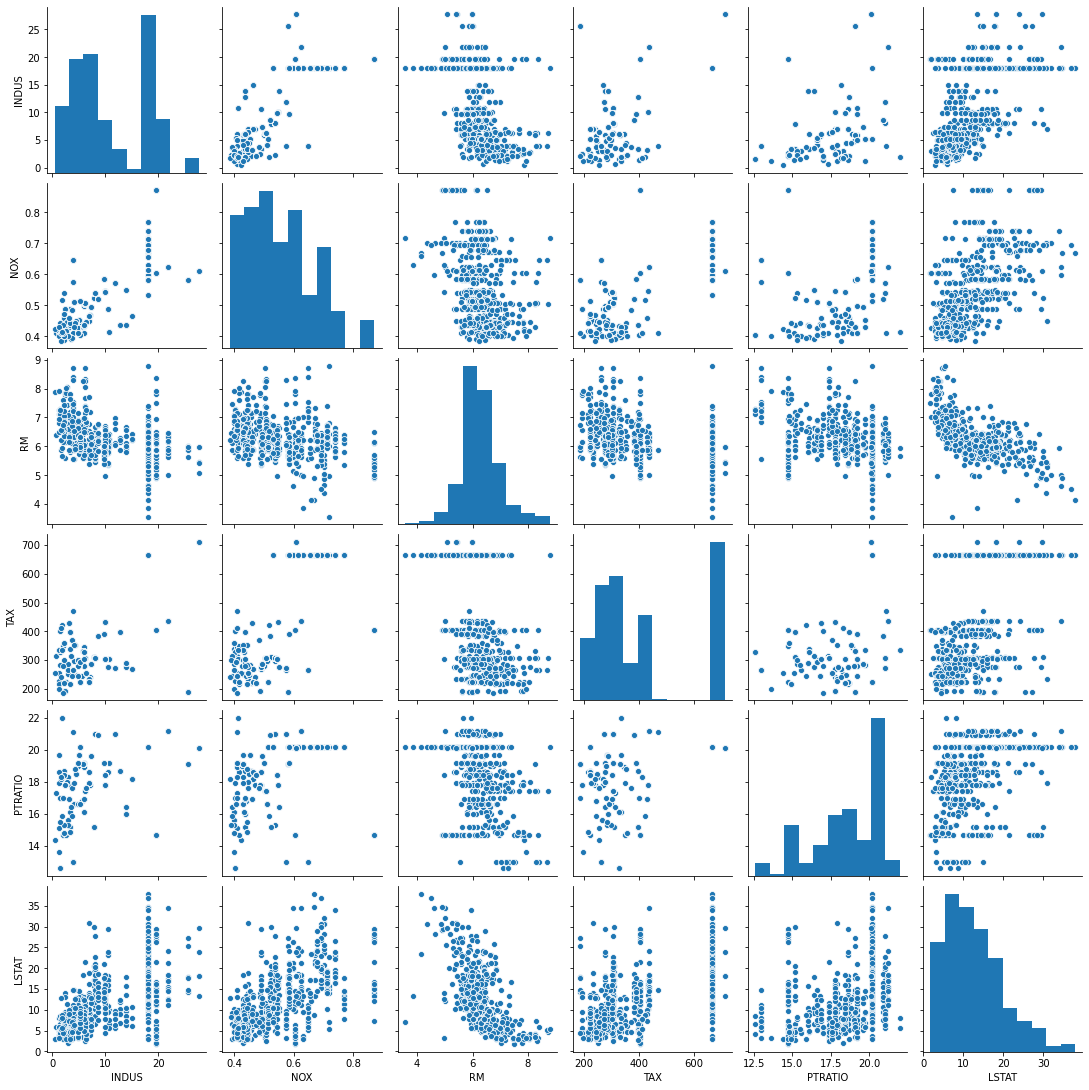

In [18]:
sns.pairplot(df)

In [19]:
print((df["TAX"] > 600).sum(), (df["TAX"] < 600).sum())
print((df["INDUS"]> 18).sum(), (df["INDUS"]< 18).sum())
df["TAX"].value_counts()

137 369
189 317


666.0    132
307.0     40
403.0     30
437.0     15
304.0     14
        ... 
187.0      1
255.0      1
313.0      1
469.0      1
280.0      1
Name: TAX, Length: 66, dtype: int64

"TAX" and "INDUS" might be considered as categorical. Might try both.

Text(0.5, 1.0, "Median value of owner-occupied homes in $1000's")

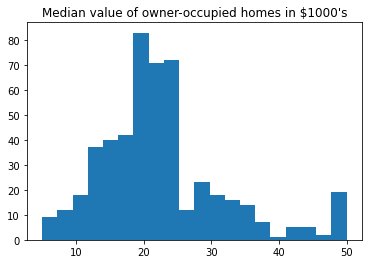

In [20]:
plt.hist(y,bins=20);
plt.title("Median value of owner-occupied homes in $1000's")

Normalizing values using max-min:

$$ \frac{X_i - X_{min}}{X_{max}-X_{min}}$$

In [21]:
df["TARGET"] = y

# Normalize_x
x = df.values #returns a numpy array
cols = df.columns
norm_fun = preprocessing.MinMaxScaler()
norm = norm_fun.fit_transform(x)   # dfn2=pd.DataFrame(renorm.inverse_transform(dfn))
dfn = pd.DataFrame(norm)
dfn.columns=cols

dfn.head()

,INDUS,NOX,RM,TAX,PTRATIO,LSTAT,TARGET
0,0.067815,0.314815,0.577505,0.208015,0.287234,0.089680,0.422222
1,0.242302,0.172840,0.547998,0.104962,0.553191,0.204470,0.368889
2,0.242302,0.172840,0.694386,0.104962,0.553191,0.063466,0.660000
3,0.063050,0.150206,0.658555,0.066794,0.648936,0.033389,0.631111
4,0.063050,0.150206,0.687105,0.066794,0.648936,0.099338,0.693333


In [29]:
dfn["TARGET"].value_counts()

1.000000    16
0.444444     8
0.402222     7
0.377778     7
0.371111     7
            ..
0.542222     1
0.157778     1
0.133333     1
0.266667     1
0.611111     1
Name: TARGET, Length: 229, dtype: int64

In [38]:
# Shuffle dataset
dfn = shuffle(dfn)
# Divide between x and y
xn=dfn.loc[:, dfn.columns != 'TARGET']
yn=dfn["TARGET"]
# Train/Test dividing using 90% train and 10% test
div = int(len(dfn)*0.9)
xn_train = xn[:div]
yn_train = yn[:div]
xn_test = xn[div:]
yn_test = yn[div:]

Fit using train dataset

In [39]:
xn_train = smf.add_constant(xn_train)
multi_lm = smf.OLS(yn_train,xn_train).fit()

In [40]:
multi_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 TARGET   R-squared:                       0.709
Model:                            OLS   Adj. R-squared:                  0.705
Method:                 Least Squares   F-statistic:                     182.2
Date:                Wed, 25 Nov 2020   Prob (F-statistic):          8.38e-117
Time:                        18:04:45   Log-Likelihood:                 355.66
No. Observations:                 455   AIC:                            -697.3
Df Residuals:                     448   BIC:                            -668.5
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3340      0.040      8.432      0.000       0.256       0.412
INDUS          0.0431      0.037      1.176      0.240      -0.029       0.115
NOX           -0.0495      0.038     -1.309      0.191      -0.124       0.025
RM             0.5961      0.052     11.541      0.000       0.495       0.698
TAX           -0.0371      0.026     -1.414      0.158      -0.089       0.014
PTRATIO       -0.1998      0.028     -7.246      0.000      -0.254      -0.146
LSTAT         -0.3808      0.042     -9.174      0.000      -0.462      -0.299
==============================================================================
Omnibus:                      183.010   Durbin-Watson:                   1.924
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              967.495
Skew:                           1.677   Prob(JB):                    8.15e-211
Kurtosis:                       9.308   Cond. No.                         19.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""